# PSD

40 min traces

author: steeve.laquitaine@epfl.ch

**Execution duration:**   

* 15 mins (4 min recordings)
* 1h (entire recordings)  

**Data description**  
**in-vivo**:

* `Marques` (aligned with cortical column)
    * rat cortex S1
    * 384ch 
    * 30.0kHz
    * 20.25 min
    * "Spontaneous activity" (Only anesthetized condition)
    
**in-silico**:

* `Neuropixels` (aligned with cortical column)
    * run: 2023_10_18
    * rat cortex S1
    * 384ch 
    * 40.0kHz
    * 10 min
    * "Spontaneous activity" (Only anesthetized condition)

Power is energy per time: can be compared between traces of different durations (sample length).

### Setup

1. Activate `spikeinterf..` venv

2. compute datasets: $sbatch cluster/figures/main/marques/psd_40m_noise_0uV_raw_welch.sbatch

3. run notebook

In [1]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import spikeinterface as si
import spikeinterface.extractors as se
import scipy
from scipy.optimize import minimize
import spikeinterface.full as si_full
from concurrent.futures import ProcessPoolExecutor
import scipy

from scipy import signal


# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.study import amplitude
from src.nodes.study import power

matplotlib.rcParams['agg.path.chunksize'] = 10000


# SETUP PARAMETERS
SFREQ_VIVO = 30000          # sampling frequency
SFREQ_SILICO = 40000        # sampling frequency

# welch PSD plots
FILT_WIND_SIZE = 30000 # 30000 -> 1Hz freq. resol. # 512500 is tuned to get a freq. resol. of 0.1 Hz
FILT_WIND_OVERLAP = int(
    FILT_WIND_SIZE // 1.5
)  # // 2 # overlap raises computational cost.
FILT_WINDOW = "hann"


# SETUP DATASET COMFIG
# vivo
data_conf_vivo, param_conf_h_vivo = get_config("vivo_marques", "c26").values()
RAW_PATH_vivo = data_conf_vivo["probe_wiring"]["output"]
PREP_PATH_vivo = data_conf_vivo["preprocessing"]["output"]["trace_file_path"]
SNR_PATH_vivo = data_conf_vivo["postprocessing"]["trace_snr"]
POWER_RAW_vivo = data_conf_vivo["analyses"]["traces"]["power"]["raw"]
POWER_PREP_vivo = data_conf_vivo["analyses"]["traces"]["power"]["preprocessed"]


# silico
data_conf_sili, param_conf_sili = get_config(
    "silico_neuropixels", "concatenated"
).values()
RAW_PATH_sili = data_conf_sili["probe_wiring"]["output_noise_20_perc_lower"]
PREP_PATH_sili = data_conf_sili["preprocessing"]["output"]["trace_file_path_noise_20_perc_lower"]


# FIGURE SETTINGS
COLOR_VIVO = (0.7, 0.7, 0.7)
COLOR_SILI = (0.84, 0.27, 0.2)
BOX_ASPECT = 1                  # square fig
LG_FRAMEON = False              # no legend frame
FIG_SIZE = (8, 3)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 30
#plt.rcParams['lines.linewidth'] = 1.1
#plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
#plt.rcParams['xtick.major.width'] = 1
#plt.rcParams['xtick.minor.size'] = 6
#plt.rcParams['xtick.major.size'] = 14
#plt.rcParams['ytick.major.size'] = 14
#plt.rcParams['ytick.major.width'] = 1
N_MAJOR_TICKS = 3
N_MINOR_TICKS = 12
YLIM = [1e-7, 1e8]
savefig_cfg = {"transparent":True}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}

2024-05-07 16:48:41,963 - root - utils.py - get_config - INFO - Reading experiment config.
2024-05-07 16:48:41,999 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-05-07 16:48:42,000 - root - utils.py - get_config - INFO - Reading experiment config.
2024-05-07 16:48:42,038 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Define custom functions

In [2]:
def load_psd_results():

    # save sili
    out_raw_sili = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/0_silico/neuropixels/concatenated_campaigns/postpro/realism/lfp/full_raw_power_welch_noise_20_perc_lower.npy",
        allow_pickle=True,
    )
    out_raw_sili = out_raw_sili.item()

    out_prep_sili = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/0_silico/neuropixels/concatenated_campaigns/postpro/realism/lfp/full_prep_power_welch_noise_20_perc_lower.npy",
        allow_pickle=True,
    )
    out_prep_sili = out_prep_sili.item()

    # save vivo
    out_raw_vivo = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/realism/1_vivo/marques/c26_fixed/postpro/full_raw_power_welch_noise_20_perc_lower.npy",
        allow_pickle=True,
    )
    out_raw_vivo = out_raw_vivo.item()

    out_prep_vivo = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/realism/1_vivo/marques/c26_fixed/postpro/full_prep_power_welch_noise_20_perc_lower.npy",
        allow_pickle=True,
    )
    out_prep_vivo = out_prep_vivo.item()

    return out_raw_sili, out_prep_sili, out_raw_vivo, out_prep_vivo


def plot_power_for_layer(
    layer: str,
    site_layers_sili: list,
    site_layers_vivo: list,
    out_raw_vivo: dict,
    out_raw_sili: dict,
):
    """plot power spectrum density for the
    specified layer

    Args:
        layer (str): layer "L1", "L2_3", "L4", "L5", "L6"
        site_layers_sili (list): layers of each in silico sites
        site_layers_vivo (list): layers of each in vivo sites
        out_raw_vivo (dict): _description_
        out_raw_sili (dict): _description_
    """

    fig, axes = plt.subplots(1, 2, figsize=FIG_SIZE)

    # Select traces in layer

    # raw
    raw_power_sili_layer_i = out_raw_sili["power"][site_layers_sili == layer, :]
    raw_power_vivo_layer_i = out_raw_vivo["power"][site_layers_vivo == layer, :]

    # preprocessed
    prep_power_sili_layer_i = out_prep_sili["power"][site_layers_sili == layer, :]
    prep_power_vivo_layer_i = out_prep_vivo["power"][site_layers_vivo == layer, :]

    # Raw panel --------------------------------

    # VIVO
    psd_mean = np.mean(raw_power_vivo_layer_i, axis=0)
    axes[0].plot(
        out_raw_vivo["freq"],
        psd_mean,  # / psd_mean.mean(),
        color=COLOR_VIVO,
        label="vivo",
    )

    # SILICO
    psd_mean = np.mean(raw_power_sili_layer_i, axis=0)
    axes[0].plot(
        out_raw_sili["freq"],
        psd_mean,  # / np.mean(psd_mean),
        color=COLOR_SILI,
        label="silico",
    )

    # legend
    axes[0].set_xlabel("Frequency (Hz)")
    axes[0].set_xlabel("")
    # axes[0].set_ylabel("Power (ratio)")
    # axes[0].set_yscale("log")
    axes[0].set_xscale("log")
    axes[0].spines[["right", "top"]].set_visible(False)
    axes[0].set_ylim(YLIM_R)
    axes[0].set_xlim([-1, SFREQ_SILICO / 2])
    axes[0].tick_params(axis="x", which="minor", colors="black")
    axes[0].tick_params(axis="x", which="major", colors="black")

    # show minor ticks
    locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
    locmin = matplotlib.ticker.LogLocator(
        base=10.0,
        subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
        numticks=N_MINOR_TICKS,
    )
    axes[0].tick_params(which="both")
    axes[0].xaxis.set_major_locator(locmaj)
    axes[0].xaxis.set_minor_locator(locmin)
    axes[0].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    # axes[0].set_xticklabels([])

    # # show minor ticks
    # locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
    # locmin = matplotlib.ticker.LogLocator(
    #     base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=N_MINOR_TICKS
    # )
    # axes[0].tick_params(which="both", width=1)
    # axes[0].xaxis.set_major_locator(locmaj)
    # axes[0].xaxis.set_minor_locator(locmin)
    # axes[0].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

    # Preprocessed panel --------------------------------

    # VIVO
    psd_mean = np.mean(prep_power_vivo_layer_i, axis=0)
    axes[1].plot(
        out_prep_vivo["freq"],
        psd_mean,  # / np.mean(psd_mean),
        color=COLOR_VIVO,
        label="vivo",
    )

    # SILICO
    psd_mean = np.mean(prep_power_sili_layer_i, axis=0)
    axes[1].plot(
        out_prep_sili["freq"],
        psd_mean,  # / np.mean(psd_mean),
        color=COLOR_SILI,
        label="silico",
    )

    # legend
    # axes[1].set_xlabel("Frequency (Hz)")
    axes[1].set_xlabel("")
    axes[1].set_xscale("log")
    axes[1].spines[["left", "right", "top"]].set_visible(False)
    axes[1].set_yticklabels([])
    axes[1].set_yticks([])
    axes[1].set_xticks([])
    # axes[1].legend(**legend_cfg)
    axes[1].set_ylim(YLIM_P)

    # # show minor ticks
    # locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
    # locmin = matplotlib.ticker.LogLocator(
    #     base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=N_MINOR_TICKS
    # )
    # axes[1].tick_params(which="both", width=1)
    # axes[1].xaxis.set_major_locator(locmaj)
    # axes[1].xaxis.set_minor_locator(locmin)
    # axes[1].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

    axes[1].set_xlim([-1, SFREQ_SILICO / 2])
    axes[1].tick_params(axis="x", which="minor", colors="black")
    axes[1].tick_params(axis="x", which="major", colors="black")

    # show minor ticks
    locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
    locmin = matplotlib.ticker.LogLocator(
        base=10.0,
        subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
        numticks=N_MINOR_TICKS,
    )
    axes[1].tick_params(which="both")
    axes[1].xaxis.set_major_locator(locmaj)
    axes[1].xaxis.set_minor_locator(locmin)
    axes[1].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    # axes[0].set_xticklabels([])

    fig.tight_layout(**tight_layout_cfg)
    return axes

### (1s) Load Welch psd for cortical sites

In [3]:
# load raw traces
RawVivo = si.load_extractor(RAW_PATH_vivo)
RawSili = si.load_extractor(RAW_PATH_sili)

# load preprocessed traces
PreprocessedVivo = si.load_extractor(PREP_PATH_vivo)
PreprocessedSili = si.load_extractor(PREP_PATH_sili)

# Keep traces sites in cortex
# silico
layers = ["L1", "L2_3", "L4", "L5", "L6"]
site_layers_sili = RawSili.get_property("layers")
site_layers_sili = [
    "L2_3" if l_i == "L2" or l_i == "L3" else l_i for l_i in site_layers_sili
]
IN_CTX = np.isin(site_layers_sili, layers)
sites_sili = np.where(IN_CTX)[0]

# vivo
site_layers_vivo = RawVivo.get_property("layers")
IN_CTX = np.isin(site_layers_vivo, layers)
sites_vivo = np.where(IN_CTX)[0]

# keep only the layers
site_layers_sili = np.array(site_layers_sili)[sites_sili]
site_layers_vivo = np.array(site_layers_vivo)[sites_vivo]

# load precomputed psd
out_raw_sili, out_prep_sili, out_raw_vivo, out_prep_vivo = load_psd_results()

#### (2m) Plot column

The PSD is averaged over sites and divided by the total power over frequencies.

In [4]:
# (11s) normalize by total power
psd_mean_raw_vivo = np.sum(out_raw_vivo["power"], axis=0)
psd_mean_raw_sili = np.sum(out_raw_sili["power"], axis=0)
psd_mean_prep_vivo = np.sum(out_prep_vivo["power"], axis=0)
psd_mean_prep_sili = np.sum(out_prep_sili["power"], axis=0)

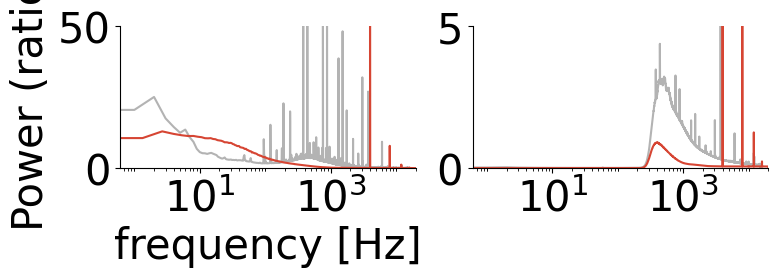

In [5]:
# takes 2 mins
# YLIM_R = [-5, 100]
# YLIM_P = [-0.5, 10]
YLIM_R = [-0.01, 50]
YLIM_P = [-0.001, 5]
N_MAJOR_TICKS = 4

fig, axes = plt.subplots(1, 2, figsize=FIG_SIZE)

# Raw panel (8 secs) --------------------------------

# VIVO
# 3 secs
axes[0].plot(
    out_raw_vivo["freq"],
    psd_mean_raw_vivo,  # / psd_mean_raw_vivo.mean(),
    color=COLOR_VIVO,
    label="vivo",
)

# SILICO
axes[0].plot(
    out_raw_sili["freq"],
    psd_mean_raw_sili,  # / np.mean(psd_mean_raw_sili),
    color=COLOR_SILI,
    label="silico",
)

# legend
axes[0].set_xscale("log")
axes[0].set_xlim([-1, SFREQ_SILICO / 2])
axes[0].set_xlabel("frequency [Hz]")
axes[0].set_ylim(YLIM_R)
axes[0].set_ylabel("Power (ratio)")
axes[0].spines[["right", "top"]].set_visible(False)
axes[0].tick_params(axis="x", which="minor", colors="black")
axes[0].tick_params(axis="x", which="major", colors="black")

# show minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
    numticks=N_MINOR_TICKS,
)
axes[0].tick_params(which="both")
axes[0].xaxis.set_major_locator(locmaj)
axes[0].xaxis.set_minor_locator(locmin)
axes[0].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# axes[0].set_xticklabels([])

# Preprocessed panel ******************

# VIVO
axes[1].plot(
    out_prep_vivo["freq"],
    psd_mean_prep_vivo,  # / np.mean(psd_mean_prep_vivo),
    color=COLOR_VIVO,
    label="vivo",
)

# SILICO
axes[1].plot(
    out_prep_sili["freq"],
    psd_mean_prep_sili,  # / np.mean(psd_mean_prep_sili),
    color=COLOR_SILI,
    label="silico",
)

# legend
axes[1].set_xscale("log")
axes[1].spines[["right", "top"]].set_visible(False)
axes[1].legend(**legend_cfg)

# show minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
    numticks=N_MINOR_TICKS,
)
axes[1].tick_params(which="both")
axes[1].xaxis.set_major_locator(locmaj)
axes[1].xaxis.set_minor_locator(locmin)
axes[1].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# axes[1].set_xticklabels([])
# axes[1].set_yticks([])
# axes[1].set_yticklabels([])
axes[1].set_ylim(YLIM_P)
axes[1].set_xlim([-1, SFREQ_SILICO / 2])

fig.tight_layout(**tight_layout_cfg)

# clear legend
axes[1].get_legend().remove()

# save
plt.savefig(
    "figures/2_realism/4_power/svg/marques/marques_40m_psd_column_raw_welch_noise_20_perc_lower.svg",
    **savefig_cfg
)

#### plot layer 1

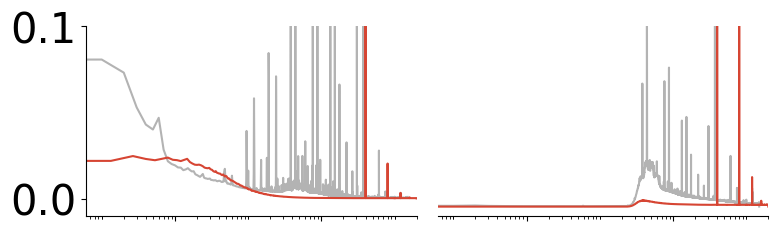

In [6]:
YLIM_R = [-0.01, 0.1]
YLIM_P = [-0.001, 0.02]

# takes 50 secs
axes = plot_power_for_layer(
    "L1", site_layers_sili, site_layers_vivo, out_raw_vivo, out_raw_sili
)
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])

# save
plt.savefig(
    "figures/2_realism/4_power/svg/marques/marques_40m_psd_layer1_column_raw_welch_noise_20_perc_lower.svg",
    **savefig_cfg
)

#### plot layer 2/3

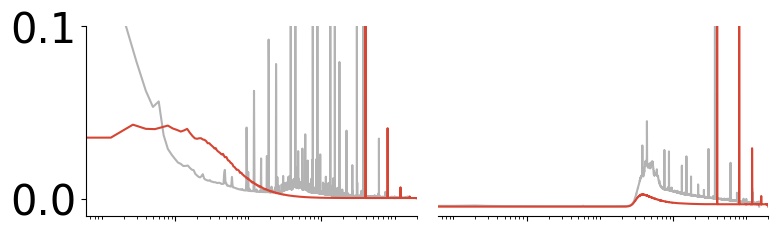

In [7]:
# takes 50 secs
axes = plot_power_for_layer(
    "L2_3", site_layers_sili, site_layers_vivo, out_raw_vivo, out_raw_sili
)
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])

plt.savefig(
    "figures/2_realism/4_power/svg/marques/marques_40m_psd_layer2_3_column_raw_welch_noise_20_perc_lower.svg",
    **savefig_cfg
)

#### plot layer 4

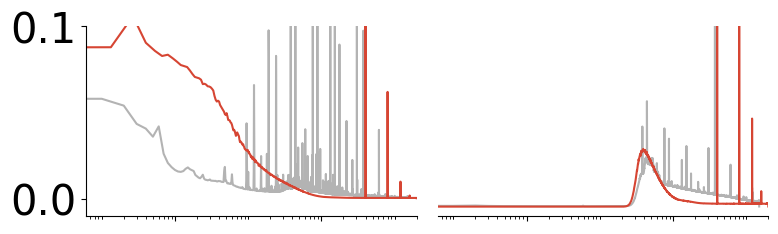

In [8]:
# takes 50 secs
axes = plot_power_for_layer(
    "L4", site_layers_sili, site_layers_vivo, out_raw_vivo, out_raw_sili
)
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])
plt.savefig(
    "figures/2_realism/4_power/svg/marques/marques_40m_psd_layer4_column_raw_welch_noise_20_perc_lower.svg",
    **savefig_cfg
)

#### plot layer 5

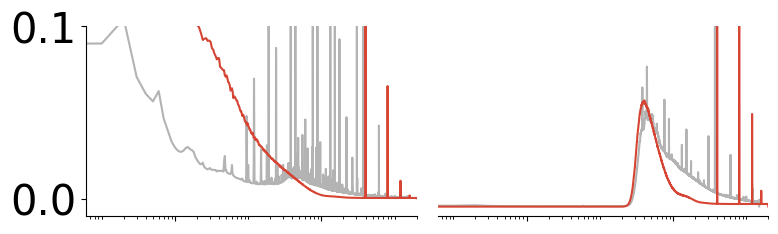

In [9]:
# takes 50 secs
axes = plot_power_for_layer(
    "L5", site_layers_sili, site_layers_vivo, out_raw_vivo, out_raw_sili
)
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])

plt.savefig(
    "figures/2_realism/4_power/svg/marques/marques_40m_psd_layer5_column_raw_welch_noise_20_perc_lower.svg",
    **savefig_cfg
)

#### plot layer 6

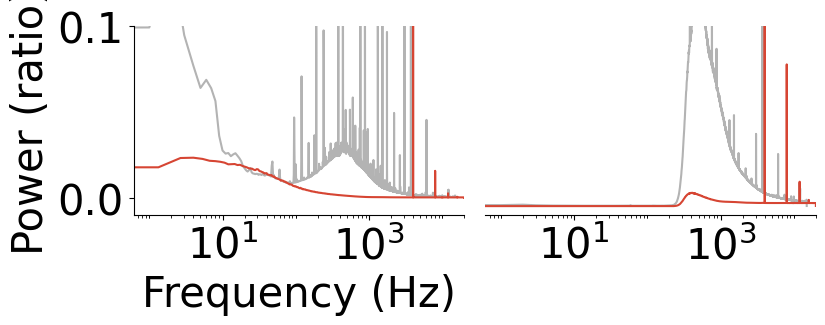

In [10]:
# takes 50 secs
axes = plot_power_for_layer(
    "L6", site_layers_sili, site_layers_vivo, out_raw_vivo, out_raw_sili
)
axes[0].set_ylabel("Power (ratio)")
axes[0].set_xlabel("Frequency (Hz)")

plt.savefig(
    "figures/2_realism/4_power/pdf/marques/marques_40m_psd_layer6_column_raw_welch_noise_20_perc_lower.pdf",
    **savefig_cfg
)
plt.savefig(
    "figures/2_realism/4_power/svg/marques/marques_40m_psd_layer6_column_raw_welch_noise_20_perc_lower.svg",
    **savefig_cfg
)

# References

see plot of known frequency scaling properties of LFP (http://www.scholarpedia.org/article/File:Diffusion-LFP.jpg)
